In [1]:
import pandas as pd
import os
from datasets import load_dataset, load_metric, Dataset, Value, ClassLabel, Features, DatasetDict
from transformers import LongformerTokenizer, LongformerForSequenceClassification, LongformerConfig, trainer, TrainingArguments
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments, EarlyStoppingCallback
import torch

seed = 42
model_name = 'allenai/longformer-base-4096'

tokenizer = LongformerTokenizer.from_pretrained(model_name, padding='max_length', truncation=True)
model = LongformerForSequenceClassification.from_pretrained(model_name)
#os.environ['WANDB_DISABLED'] = 'true'

seed = 42

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Build Dataset

In [2]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/multirc.csv')#[['source_text', 'source_text_clean', 'question_text', 'answer_text', 'is_correct']]
df['text'] = df['answer_text'] + tokenizer.sep_token + df['question_text'] + tokenizer.sep_token + df['source_text_clean']

df = df[['text', 'is_correct', 'source_text_clean']]
df.columns = ['text', 'labels', 'source_text_clean']
df['labels'] = df['labels'].apply(lambda x: 0 if x == False else 1)

source_index = df['source_text_clean'].drop_duplicates()
train_index, validtest_index = train_test_split(source_index, test_size=0.3,train_size=0.7, random_state = seed)
valid_index, test_index = train_test_split(validtest_index, test_size=0.5, train_size=0.5, random_state = seed)

train_df = df[df['source_text_clean'].isin(train_index)].dropna()[['text', 'labels']]
valid_df = df[df['source_text_clean'].isin(valid_index)].dropna()[['text', 'labels']]
test_df = df[df['source_text_clean'].isin(test_index)].dropna()[['text', 'labels']]

print(len(train_df))
print(len(valid_df))
print(len(test_df))

ds = DatasetDict()
ds['train'] = Dataset.from_pandas(train_df, preserve_index=False)
ds['valid'] = Dataset.from_pandas(valid_df, preserve_index=False)
ds['test'] = Dataset.from_pandas(test_df, preserve_index=False)
print(ds)
def preprocess_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)
    
ds = ds.map(preprocess_function)
print(ds)

19189
4080
3962
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 19189
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 4080
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 3962
    })
})


Map:   0%|          | 0/19189 [00:00<?, ? examples/s]

Map:   0%|          | 0/4080 [00:00<?, ? examples/s]

Map:   0%|          | 0/3962 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 19189
    })
    valid: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 4080
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 3962
    })
})


## Train Model

In [3]:
id2label = {0: "incorrect_answer", 1: "correct_answer"}
label2id = {"incorrect_answer": 0, "correct_answer": 1}

def model_init():
    model = LongformerForSequenceClassification.from_pretrained("../bin/longformer_classifier",
                                                               num_labels=2,
                                                               id2label=id2label,
                                                               label2id=label2id)
    return model

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

print(device)

cuda


In [4]:
import evaluate
import numpy as np
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [5]:
model_max_length = 4096
eval_steps = 1000
eval_accumulation_steps = 2
save_total_limit = 4
batch_size = 8
num_epochs = 4
learning_rate = 3e-05
seed = 42

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='max_length', max_length=4096)

In [ ]:
import os
os.environ['WANDB_DISABLED'] = 'true'

trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir = f'./results/mpnet_checkpoints',
    optim = 'adamw_torch',
    num_train_epochs = 3,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    learning_rate = learning_rate,
    gradient_accumulation_steps=4, 
    gradient_checkpointing=True,
    logging_dir = f'./logs/content',
    save_total_limit = 10,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    evaluation_strategy = "epoch",
    save_strategy = "epoch", 
    greater_is_better = True,
    seed=seed,
    log_level = 'error',  
    disable_tqdm = False, 
) 

    # Call the Trainer
trainer = Trainer(
    model_init = model_init,
    args = training_args,
    data_collator=data_collator,
    train_dataset = ds['train'],
    eval_dataset = ds['valid'],
    compute_metrics = compute_metrics
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss


In [ ]:
ds['train']['labels']

In [ ]:
import time

start_time = time.time()
preds, labels, metrics= trainer.predict(ds['test'])
predictions = np.argmax(preds, axis=1)
end_time = time.time()
print(end_time-start_time)

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt

confusion_matrix = metrics.confusion_matrix(labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['incorrect', 'correct'])

cm_display.plot()
plt.title('Predicted and True Classifications of Correct and Incorrect Answers (MPnet)')
plt.show()

In [ ]:
print(metrics.classification_report(labels, predictions))

In [ ]:
import sklearn
sklearn.metrics.cohen_kappa_score(labels, predictions)

In [ ]:
trainer.save_model("../bin/longformer_classifier")

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained("../bin/longformer_classifier")
tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')

In [4]:
model.push_to_hub('tiedaar/short-answer-classification-longformer')
tokenizer.push_to_hub('tiedaar/short-answer-classification-longformer')

CommitInfo(commit_url='https://huggingface.co/tiedaar/short-answer-classification-longformer/commit/555ca43c68067b517aaf1ff726ee58840d1c0a30', commit_message='Upload tokenizer', commit_description='', oid='555ca43c68067b517aaf1ff726ee58840d1c0a30', pr_url=None, pr_revision=None, pr_num=None)

In [7]:
counter = 0
preds = []
for text in ds['test']['text']:
    print(f"Processing item {counter} of {len(ds['test']['text'])}", end='\r')
    counter += 1
    inputs = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    preds.append(model.config.id2label[predicted_class_id])

In [8]:
len(preds)

3962

In [9]:
labels = []
for x in ds['test']['labels']:
    if x == 1:
        labels.append('correct_answer' )
    else: 
        labels.append('incorrect_answer') 

from sklearn import metrics
from matplotlib import pyplot as plt

print(metrics.classification_report(labels, preds))

                  precision    recall  f1-score   support

  correct_answer       0.66      0.71      0.68      1722
incorrect_answer       0.76      0.71      0.74      2240

        accuracy                           0.71      3962
       macro avg       0.71      0.71      0.71      3962
    weighted avg       0.72      0.71      0.71      3962



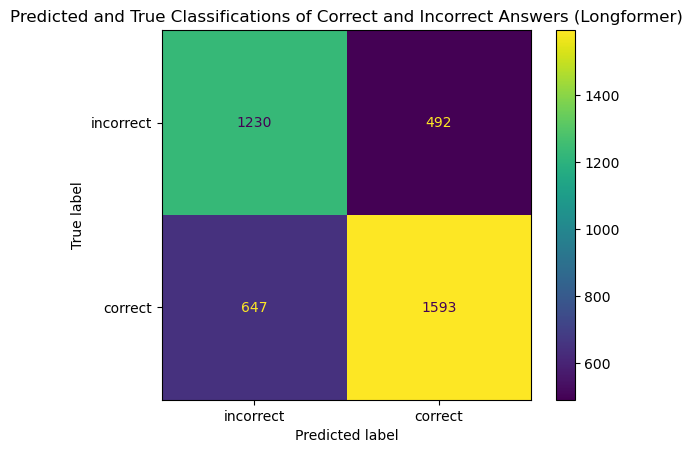

In [11]:
from sklearn import metrics
from matplotlib import pyplot as plt

confusion_matrix = metrics.confusion_matrix(labels, preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['incorrect', 'correct'])

cm_display.plot()
plt.title('Predicted and True Classifications of Correct and Incorrect Answers (Longformer)')
plt.show()